In [22]:
!pip3 install datasets
import pandas as pd
from datasets import load_dataset

yelp_data_set = load_dataset("yelp_review_full")

# Split into training data
train_data = yelp_data_set['train']
test_data = yelp_data_set['test']

# Convert training data to pandas DataFrame
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [23]:
# Get the size of train_data and test_data
train_size = len(train_data)
test_size = len(test_data)

print("Size of training data:", train_size)
print("Size of test data:", test_size)


# Print out the first 5 rows of the DataFrame
print(train_df.head())


Size of training data: 650000
Size of test data: 50000
   label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...


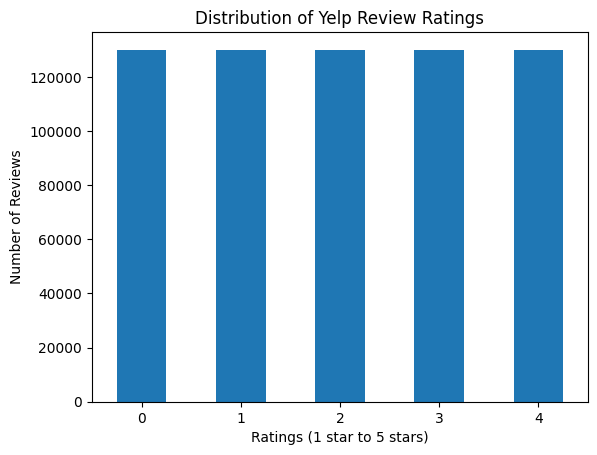

KeyboardInterrupt: 

In [24]:
import matplotlib.pyplot as plt

# Plotting the distribution of ratings
train_df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Yelp Review Ratings')
plt.xlabel('Ratings (1 star to 5 stars)')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)  # Keeps the labels horizontal
plt.show()

# Adding a new column for review length
train_df['review_length'] = train_df['text'].apply(len)

# Plotting the distribution of review lengths
plt.figure(figsize=(10, 5))
plt.hist(train_df['review_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.show()

# Displaying examples of reviews for each rating
for label in sorted(train_df['label'].unique()):
    sample_review = train_df[train_df['label'] == label].iloc[0]
    print(f"Rating: {label} stars\nReview: {sample_review['text']}\n" + "-"*50)


In [ ]:

# Shuffle the test dataset
shuffled_test_data = test_data.shuffle(seed=42)  # You can adjust the seed value for reproducibility

# Take a sample from the shuffled test data
sampled_test_data = shuffled_test_data[:500]  # Adjust the slice to the desired sample size
sampled_test_df = pd.DataFrame(sampled_test_data)
# sampled_test_df = sampled_test_df[sampled_test_df['label'] != 3] 

print(sampled_test_df.head())


   label                                               text
0      2  Kabuto is your run-of-the-mill Japanese Steakh...
1      4  Visiting here for 10 days and staying in a con...
2      1                             Terrible terrible food
3      4  This is a beautiful theatre with a gorgeous gl...
4      3  I don't quite get this place or why Asians lov...


In [ ]:
def preprocess_text(text):
    max_token_limit = 512
    # min_token_limit = 40
    if len(text) > max_token_limit:
        return text[:512]
    else:
        return text

In [30]:
from transformers import pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Load pipelines for each model
pipeline_1 = pipeline(task='sentiment-analysis', model='gilf/english-yelp-sentiment')

def perform_sentiment_analysis_1(text):
    sentiment_prediction = pipeline_1(preprocess_text(text))[0]
    sentiment_prediction_label = int(sentiment_prediction['label'][:1])-1
    sentiment_prediction_score=sentiment_prediction['score']
    return [sentiment_prediction_label, sentiment_prediction_score]

predictions_df = pd.DataFrame({'actual_score': sampled_test_df['label'], 'text': sampled_test_df['text']})

predictions_df[['prediction_label','prediction_score']] = sampled_test_df['text'].apply(perform_sentiment_analysis_1).apply(pd.Series)


In [44]:
accuracy_1 = accuracy_score(predictions_df['actual_score'], predictions_df['prediction_label'])
print(accuracy_1)

0.666


In [43]:
# overall we can tell the modal did a pretty good job on 
conf_matrix = confusion_matrix(predictions_df['prediction_label'], predictions_df['actual_score'])
print(conf_matrix)

# Define TF and FT rows based on prediction score and actual score
false_negative_rows = predictions_df[(predictions_df['prediction_label'] != predictions_df['actual_score']) & 
                          ((predictions_df['prediction_label'] == 0) | (predictions_df['prediction_label'] == 1)) & 
                          ((predictions_df['actual_score'] == 3) | (predictions_df['actual_score'] == 4))]

false_positive_rows = predictions_df[(predictions_df['prediction_label'] != predictions_df['actual_score']) & 
                           ((predictions_df['prediction_label'] == 3) | (predictions_df['prediction_label'] == 4)) & 
                          ((predictions_df['actual_score'] == 0) | (predictions_df['actual_score'] == 1))]


print("Text for false negative results:")
for idx, row in false_negative_rows.iterrows():
    print('prediction: ', row['prediction_label'], ' actual: ', row['actual_score'])
    print(row['text'])
    print("\n")

print("\nText for false positive results:")
for idx, row in false_positive_rows.iterrows():
    print('prediction: ', row['prediction_label'], ' actual: ', row['actual_score'])
    print(row['text'])
    print("\n")


[[73 13  0  2  0]
 [35 77 14  0  0]
 [ 2 18 57  8  2]
 [ 0  3 20 70 28]
 [ 0  1  1 20 56]]
Text for false negative results:
prediction:  0.0  actual:  3
Was in conference at the Phoenix Convention Center and a glorious smell wafted through from the east. Turning to my left I saw a plate, and lady tearing something up..fiercely . Me and three other people immediately stopped what we were doing and walked somewhat zombie like to where the food was and asked...where did you get that? Karim's Cobbler Shop and Deli was her reply...in between bites.  \n\nNow I've been in Phoenix for 3 months looking for a taste of soul food. And here it was in my back yard! I was shocked!!!\n\nWith a sense of urgency I walked the streets until once again I was seduced by the smell of fried fish. Wasnt very far, and it was perched right in front of the Light Rail.  My kind of place.\n\nFirst thought, very humble. Very clean and neat and humble.  The owner was very kind, friendly and humble. Very confident tha

# analysis:
#
# false negative breakdown:
#   - in another language, modal gave a 0 label
#   - very very long text, ambigious whether it is positive or negative, modal gave 0, actual 3
#
# false positive breakdown:
#   - modal gave mostly 3, one 4 on actual 1 reviews. 
#   - negative words like 'never' 'without' 'can't' might affected the prediction
#

In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define a function to apply sentiment analysis over a batch of reviews
tokenizer = AutoTokenizer.from_pretrained("milyiyo/multi-minilm-finetuned-amazon-review")
model = AutoModelForSequenceClassification.from_pretrained("milyiyo/multi-minilm-finetuned-amazon-review")
pipeline_2 = pipeline(task='sentiment-analysis', model=model,tokenizer=tokenizer)

def perform_sentiment_analysis_2(text):
    sentiment_prediction = pipeline_2(preprocess_text(text))[0]
    sentiment_prediction_label = int(sentiment_prediction['label'][6])
    sentiment_prediction_score=sentiment_prediction['score']
    return [sentiment_prediction_label, sentiment_prediction_score]


predictions_2_df = pd.DataFrame({'actual_score': sampled_test_df['label'], 'text': sampled_test_df['text']})

predictions_2_df[['prediction_label','prediction_score']] = sampled_test_df['text'].apply(perform_sentiment_analysis_2).apply(pd.Series)


In [ ]:
accuracy_2 = accuracy_score(predictions_2_df['actual_score'], predictions_2_df['prediction_label'])
print(accuracy_2)

print(predictions_2_df.columns)

0.434
Index(['actual_score', 'text', 'prediction_label', 'prediction_score'], dtype='object')


In [45]:

# overall we can tell the modal did a pretty good job on 
conf_matrix = confusion_matrix(predictions_2_df['prediction_label'], predictions_2_df['actual_score'])
print(conf_matrix)

# Define TF and FT rows based on prediction score and actual score
false_negative_rows = predictions_2_df[(predictions_2_df['prediction_label'] != predictions_2_df['actual_score']) & 
                          ((predictions_2_df['prediction_label'] == 0) | (predictions_2_df['prediction_label'] == 1)) & 
                          ((predictions_2_df['actual_score'] == 3) | (predictions_2_df['actual_score'] == 4))]

false_positive_rows = predictions_2_df[(predictions_2_df['prediction_label'] != predictions_2_df['actual_score']) & 
                           ((predictions_2_df['prediction_label'] == 3) | (predictions_2_df['prediction_label'] == 4)) & 
                          ((predictions_2_df['actual_score'] == 0) | (predictions_2_df['actual_score'] == 1))]


print("Text for false negative results:")
for idx, row in false_negative_rows.iterrows():
    print('prediction: ', row['prediction_label'], ' actual: ', row['actual_score'])
    print(row['text'])
    print("\n")

print("\nText for false positive results:")
for idx, row in false_positive_rows.iterrows():
    print('prediction: ', row['prediction_label'], ' actual: ', row['actual_score'])
    print(row['text'])
    print("\n")

[[50 20  5  4  3]
 [39 49 13  7  2]
 [16 30 33 15  5]
 [ 2  8 24 20 11]
 [ 3  5 17 54 65]]
Text for false negative results:
prediction:  1.0  actual:  3
Enough variety for me. Only reason I go to buffet - Shrimp, Oysters, Sushi and Salmon. They had all of these, so I'm happy. If you are looking for a quality buffet, skip this one . It didn't look clean and I had my waitress sit on our side table facing us while we eat. Annoyed, but I don't care much. Total bill without drinks, with tax - $22.64. \n\nI will come back here again over Lin's. I won't bring guests here though!


prediction:  0.0  actual:  3
I have only been to MADCAP once, to see \"Until the Light Takes Us\" - a documentary about KVLT Norwegian Black Metal. I am very excited to have a theater playing REAL independent films and cult classics nearby. I frequently visited Chandler Cinemas to see films put on by Midnight Movie Mamacita - Cannibal Holocaust, El Topo, The Holy Mountain, Re-animator, Black Christmas.. etc. I was v

# analysis:
#
# false negative breakdown:
#   - words like 'only' 'once' 'won't' 'closed!!!' 'why' '?' '!' 'too bad' are used, modal get confused easily on excalaimation sentences
#   - seeing more false negative compared to last modal
#
# false positive breakdown:
#   - reviews are mixed with good and bad comments. 'used to love' 'loved', also 'comfortable' etc were mixed in bad words. Modal seems to give more weight on positive words
#

In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define a function to apply sentiment analysis over a batch of reviews
tokenizer_3 = AutoTokenizer.from_pretrained("nihaldsouza1/yelp-rating-classification")
model_3 = AutoModelForSequenceClassification.from_pretrained("nihaldsouza1/yelp-rating-classification")
pipeline_3 = pipeline(task='sentiment-analysis', model=model_3,tokenizer=tokenizer_3)

def perform_sentiment_analysis_3(text):
    sentiment_prediction = pipeline_3(preprocess_text(text))[0]
    sentiment_prediction_label = int(sentiment_prediction['label'][0])-1
    sentiment_prediction_score=sentiment_prediction['score']
    return [sentiment_prediction_label, sentiment_prediction_score]


predictions_3_df = pd.DataFrame({'actual_score': sampled_test_df['label'], 'text': sampled_test_df['text']})

predictions_3_df[['prediction_label','prediction_score']] = sampled_test_df['text'].apply(perform_sentiment_analysis_3).apply(pd.Series)

In [ ]:
accuracy_3 = accuracy_score(predictions_3_df['actual_score'], predictions_3_df['prediction_label'])
print(accuracy_3)

print(predictions_3_df.columns)

0.58
Index(['actual_score', 'text', 'prediction_label', 'prediction_score'], dtype='object')


In [46]:

# overall we can tell the modal did a pretty good job on 
conf_matrix = confusion_matrix(predictions_3_df['prediction_label'], predictions_3_df['actual_score'])
print(conf_matrix)

# Define TF and FT rows based on prediction score and actual score
false_negative_rows = predictions_3_df[(predictions_3_df['prediction_label'] != predictions_3_df['actual_score']) & 
                          ((predictions_3_df['prediction_label'] == 0) | (predictions_3_df['prediction_label'] == 1)) & 
                          ((predictions_3_df['actual_score'] == 3) | (predictions_3_df['actual_score'] == 4))]

false_positive_rows = predictions_3_df[(predictions_3_df['prediction_label'] != predictions_3_df['actual_score']) & 
                           ((predictions_3_df['prediction_label'] == 3) | (predictions_3_df['prediction_label'] == 4)) & 
                          ((predictions_3_df['actual_score'] == 0) | (predictions_3_df['actual_score'] == 1))]


print("Text for false negative results:")
for idx, row in false_negative_rows.iterrows():
    print('prediction: ', row['prediction_label'], ' actual: ', row['actual_score'])
    print(row['text'])
    print("\n")

print("\nText for false positive results:")
for idx, row in false_positive_rows.iterrows():
    print('prediction: ', row['prediction_label'], ' actual: ', row['actual_score'])
    print(row['text'])
    print("\n")

[[86 41  8  3  4]
 [22 42 10  2  1]
 [ 1 23 55 11  4]
 [ 1  5 18 46 16]
 [ 0  1  1 38 61]]
Text for false negative results:
prediction:  1.0  actual:  3
I have only been to MADCAP once, to see \"Until the Light Takes Us\" - a documentary about KVLT Norwegian Black Metal. I am very excited to have a theater playing REAL independent films and cult classics nearby. I frequently visited Chandler Cinemas to see films put on by Midnight Movie Mamacita - Cannibal Holocaust, El Topo, The Holy Mountain, Re-animator, Black Christmas.. etc. I was very disappointed to see that theater go. When I found out that she'd been relocated to continue the tradition at MADCAP, I rejoiced. I look forward to seeing many movies here in the future.


prediction:  1.0  actual:  3
I don't have a whole lot of experience with liquor stores, but have always been pleased here.  The staff are always nice, helpful, and non-intrusive.\n\nI once went with my boyfriend, who expressed a desire for a certain beer that they 

# analysis:
#
# false negative breakdown:
#   - sentences are confusing. 'angry I haven't come sooner.' modal did not do a good job analyzing semantic meanings.
#   - negative words are used: won't, can't
#
# false positive breakdown:
#   - past tense positive reviews confused the modal: 'had a pretty good time', 'was really good', 'had a great..' followed with 'I was wrong'
#   - foreign language not regonized by modal

In [ ]:
# Text Summarization
summarizer = pipeline("summarization", model="Falconsai/text_summarization")

def perform_summarizing(text):
    processedText = preprocess_text(text)
    summary = summarizer(processedText, min_length=20, max_length=512)[0]['summary_text']
    print(summary)
    return summary

sampled = sampled_test_df.sample(n=300, random_state=42)
summary_df = pd.DataFrame({'actual_score': sampled['label'], 'text': sampled['text']})


summary_df['summary'] = summary_df['text'].apply(perform_summarizing)
print(summary_df.head())


### After summarization, we applied the previous used three kinds of sentiment analysis on summarized data, and we are observing a decrease of accuracy in all three methods. 

In [26]:
summary_df[['prediction_1_label','prediction_1_score']] = summary_df['summary'].apply(perform_sentiment_analysis_1).apply(pd.Series)
summary_df[['prediction_2_label','prediction_2_score']] = summary_df['summary'].apply(perform_sentiment_analysis_2).apply(pd.Series)
summary_df[['prediction_3_label','prediction_3_score']] = summary_df['summary'].apply(perform_sentiment_analysis_3).apply(pd.Series)

accuracy_summary_1 = accuracy_score(summary_df['actual_score'], summary_df['prediction_1_label'])
accuracy_summary_2 = accuracy_score(summary_df['actual_score'], summary_df['prediction_2_label'])
accuracy_summary_3 = accuracy_score(summary_df['actual_score'], summary_df['prediction_3_label'])

# sampled_test_df_backup[['prediction_1_label','prediction_1_score']] = sampled_test_df_backup['summary'].apply(perform_sentiment_analysis_1).apply(pd.Series)
# sampled_test_df_backup[['prediction_2_label','prediction_2_score']] = sampled_test_df_backup['summary'].apply(perform_sentiment_analysis_2).apply(pd.Series)
# sampled_test_df_backup[['prediction_3_label','prediction_3_score']] = sampled_test_df_backup['summary'].apply(perform_sentiment_analysis_3).apply(pd.Series)

# accuracy_summary_1 = accuracy_score(sampled_test_df_backup['actual_score'], sampled_test_df_backup['prediction_1_label'])
# accuracy_summary_2 = accuracy_score(sampled_test_df_backup['actual_score'], sampled_test_df_backup['prediction_2_label'])
# accuracy_summary_3 = accuracy_score(sampled_test_df_backup['actual_score'], sampled_test_df_backup['prediction_3_label'])


print('before summary_1: ', accuracy_1)
print('accuracy_summary_1: ', accuracy_summary_1)
print('before summary_2: ', accuracy_2)
print('accuracy_summary_2: ', accuracy_summary_2)
print('before summary_3: ', accuracy_3)
print('accuracy_summary_3: ', accuracy_summary_3)


before summary_1:  0.666
accuracy_summary_1:  0.5033333333333333
before summary_2:  0.434
accuracy_summary_2:  0.3566666666666667
before summary_3:  0.58
accuracy_summary_3:  0.4766666666666667


In [ ]:
### randomly select 100 rows and manually mark the categories

In [ ]:


# sampled = sampled_test_df.sample(n=100, random_state=42)

# # Export selected rows to CSV
# sampled.to_csv('./random_100.csv', index=True)


In [27]:
import pandas as pd
# Read DataFrame from CSV file
manually_marked_df = pd.read_csv('./manually_marked_df.csv')

# Display the first few rows of the DataFrame
print(manually_marked_df.head())

   Unnamed: 0  label                                               text  \
0         361      0  If you've ever eaten good Mexican food in your...   
1          73      3  Everything you need is here.\n\nWe stayed here...   
2         374      3  We went for an early Saturday night dinner, dr...   
3         155      3  This is a new fav happy hour place for us, we'...   
4         104      1  I dunno, I was drunk when I got there.  It's a...   

      category  
0  restaurants  
1       hotels  
2  restaurants  
3  restaurants  
4          bar  


# Three zero-shot classification modal

In [28]:
candidate_labels = [
    "restaurants",
    "bars",
    "coffee shops",
    "hotels",
    "salons/barbershops",
    "auto repair",
    "home services",
    "medical services",
    "entertainment",
    "pet services",
    "financial services",
    "travel & tourism",
    "education",
    "real estate",
    "fitness",
    "landscaping & gardening services",
    "legal services",
    "photography services",
    "childcare services",
    "computer & technology services"
]

In [29]:
# bart
from transformers import pipeline
facebook_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def perform_facebook_classifier(text):
    output = facebook_classifier(preprocess_text(text), candidate_labels)
    # Find the index of the label with the highest score
    max_index = output['scores'].index(max(output['scores']))

    # Get the label with the highest score
    max_label = output['labels'][max_index]

    # Get the score of the label with the highest score
    max_score = output['scores'][max_index]
    return [max_label, max_score]

manually_marked_df[['predication_category', 'predication_category_score']] = manually_marked_df['text'].apply(perform_facebook_classifier).apply(pd.Series)

KeyboardInterrupt: 

In [ ]:
accuracy_class_predict = accuracy_score(manually_marked_df['category'], manually_marked_df['predication_category'])
print(accuracy_class_predict)

0.58


In [ ]:
!pip3 install sentencepiece
# deberta classifier
from transformers import pipeline

deberta_classifier = pipeline("zero-shot-classification",model="sileod/deberta-v3-base-tasksource-nli")


def perform_deberta_classifier(text):
    output = deberta_classifier(preprocess_text(text), candidate_labels)
    # Find the index of the label with the highest score
    max_index = output['scores'].index(max(output['scores']))

    # Get the label with the highest score
    max_label = output['labels'][max_index]

    # Get the score of the label with the highest score
    max_score = output['scores'][max_index]
    return [max_label, max_score]

manually_marked_df[['deberta_predication_category', 'deberta_predication_category_score']] = manually_marked_df['text'].apply(perform_deberta_classifier).apply(pd.Series)

accuracy_class_predict = accuracy_score(manually_marked_df['category'], manually_marked_df['deberta_predication_category'])
print(accuracy_class_predict)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


KeyboardInterrupt: 

## why not T5
### T5 is not supported in zero-shot classification pipeline because it does not have a sequence classification head. With T5 the seq classification problem is formulated as text-to-text generation problem which is not possible to support in this zero-shot pipeline.

In [ ]:
# deberta-v3-large-zeroshot

deberta_large_classifier = pipeline("zero-shot-classification", model="sileod/deberta-v3-base-tasksource-nli")


def perform_deberta_large_classifier(text):
    output = deberta_large_classifier(preprocess_text(text), candidate_labels)
    # Find the index of the label with the highest score
    max_index = output['scores'].index(max(output['scores']))

    # Get the label with the highest score
    max_label = output['labels'][max_index]

    # Get the score of the label with the highest score
    max_score = output['scores'][max_index]
    return [max_label, max_score]

manually_marked_df[['deberta_large_predication_category', 'deberta_large_predication_category_score']] = manually_marked_df['text'].apply(perform_deberta_large_classifier).apply(pd.Series)

accuracy_class_predict = accuracy_score(manually_marked_df['category'], manually_marked_df['deberta_large_predication_category'])
print(accuracy_class_predict)
